Augment the literature data

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, data_aug_knn, perform_eval
from modelval.ArbDataGen import arb_w_gen, data_Gen
from modelval.spk_visu import spk_see, raster
from modelval import gp_regressor
from modelval import data_aug_gp
from sklearn.model_selection import train_test_split
from modelval.kernel import KernelGen

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [4]:
# Generate cv for training and validation data given the test fold
data_gen_train, data_gen_vali, data_gen_test, y_train, y_vali, y_test = data_Gen(data, test_fold_num=0)

In [6]:
# Visualize kernel
vali_err = np.zeros(len(data_gen_train))
kernel_pre = []
kernel_post = []
kernel_post_post = []
fc_w = []
bias = []
scale = []

ker_test = KernelGen()

fold=0

len_kernel = 101
len_trip = 151
ker_test = KernelGen(len_kernel=len_kernel, len_trip=len_trip)

# Generat the spike trains and targets for STDP
data_hippo = data[data['ptl_idx']<5]
ptl_list = [1,2,3,4]
spk_len = int(data_hippo['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [1,1,1,1]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train[fold], ptl_list=ptl_list, targets=y_train[fold], if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times, seed=723)
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali[fold], ptl_list=ptl_list, targets=y_vali[fold], if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times, seed=606)

# Create the network
ground_truth_init = 0
reg_scale=(1,1,100,200)
init_seed=(4,5,6,7,8)

toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug_gp_mean_noise_alpha1_alpha3_10_long_post_post_diff_bias' + 'cv' + str(fold)
toy_net_trainer = trainer.Trainer(toy_data_net.mse, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

# Package the data
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for _ in range(iterations):
    mini_vali_loss = toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

vali_err[i] = mini_vali_loss
toy_net_trainer.restore_best()
w_pre.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre))
w_post.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_post))
w_post_post.append(toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post))
fc_w.append(toy_net_trainer.evaluate(ops=toy_data_net.fc_w))
bias.append(toy_net_trainer.evaluate(ops=toy_data_net.bias))
scale.append(toy_net_trainer.evaluate(ops=toy_data_net.scaler))


Initial validation mse=159.24588
Global Step 0150 and Step 0150: validation mse=133.38208
Updated min validation loss!Saving model...
Global Step 0200 and Step 0200: validation mse=128.71376
Updated min validation loss!Saving model...
Global Step 0250 and Step 0250: validation mse=122.76202
Updated min validation loss!Saving model...
Global Step 0300 and Step 0300: validation mse=115.17812
Updated min validation loss!Saving model...
Global Step 0350 and Step 0350: validation mse=106.00658
Updated min validation loss!Saving model...
Global Step 0400 and Step 0400: validation mse=95.79094
Updated min validation loss!Saving model...
Global Step 0450 and Step 0450: validation mse=84.27122
Updated min validation loss!Saving model...
Global Step 0500 and Step 0500: validation mse=71.47044
Updated min validation loss!Saving model...
Global Step 0550 and Step 0550: validation mse=58.90564
Updated min validation loss!Saving model...
Global Step 0600 and Step 0600: validation mse=48.01554
Updat

NameError: name 'i' is not defined

In [7]:
vali_err

array([ 0.,  0.,  0.,  0.,  0.])

[array([-1.43309343, -1.97685266,  4.94732666], dtype=float32), array([[ 0.65506017],
       [ 0.11003124],
       [-3.15956783],
       [-1.0529418 ]], dtype=float32), array([[ 3.57077169],
       [ 1.57127333],
       [ 0.92292601],
       [ 1.71839118]], dtype=float32)]


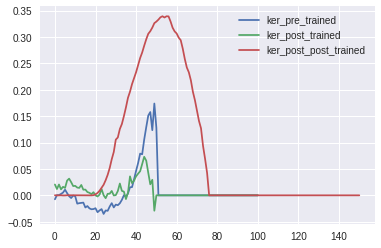

In [8]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
scaler = toy_net_trainer.evaluate(ops=toy_data_net.scaler)

plt.plot(-1*w_pre, label='ker_pre_trained')

plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1*w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias, scaler])

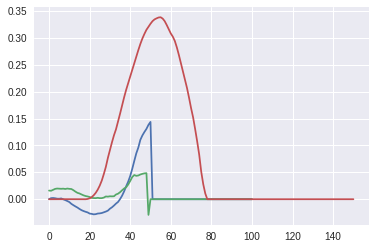

In [9]:
# Test effect of smoothed kernel
w_pre_sm = w_pre
w_post_sm = w_post 
w_post_post_sm = w_post_post
w_pre_sm[:51] = data_aug_gp.smooth(w_pre[:51], width=10)
w_post_sm[:49] = data_aug_gp.smooth(w_post[:49], width=10)
w_post_post_sm[:100] = data_aug_gp.smooth(w_post_post[:100], width=5)

plt.plot(-1 * w_pre_sm)
plt.plot(-1 * w_post_sm)
plt.plot(-1*w_post_post_sm)

ker_test.kernel_pre = w_pre_sm
ker_test.kernel_post = w_post_sm
ker_test.kernel_post_post= w_post_post_sm
ker_test.kernel_scale = fc_w
ker_test.bias = bias
ker_test.scale = scaler

Compare the target and prediction

In [10]:
# Updated the kernel as trained kernel
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias
ker_test.scale = scaler

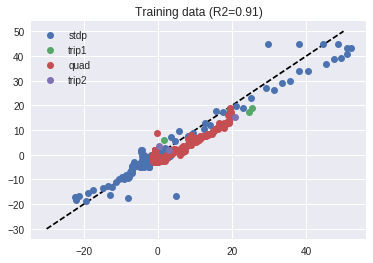

In [12]:
# Generate training predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_train = arb_w_gen(spk_pairs=spk_pairs_train, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([160,3,160,3])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_gp.target_pred_gen(targets_train, predictions_train, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_train-targets_train))/(np.square(np.std(targets_train))*(len(targets_train)-1))

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Training data (R2=%0.2f)'%(R2))
plt.legend()

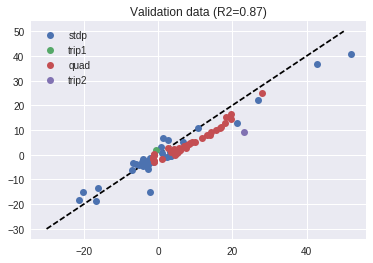

In [14]:
# Generate validation predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_vali = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([40,1,40,1])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_gp.target_pred_gen(targets_vali, predictions_vali, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_vali-targets_vali))/(np.square(np.std(targets_vali))*(len(targets_vali)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Validation data (R2=%0.2f)'%(R2))
plt.legend()

In [21]:
y_test.shape

(31, 1)

In [23]:
# Generat the spike trains and targets for STDP
data3 = data[data['ptl_idx']==3]
ptl_list = [1,2,3,4]
spk_len = int(data3['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]

spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test[0], ptl_list=ptl_list, targets=y_test, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [31]:
predictions_test.shape

(31, 1)

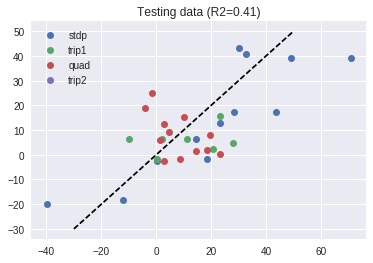

In [32]:
# Generate test predictions
spk_len = int(data['train_len'].max() * 1000 / ker_test.reso_kernel)
_, predictions_test = arb_w_gen(spk_pairs=spk_pairs_test, spk_len=spk_len, kernel=ker_test, net_type='triplet')

ptl_len = np.array([12,7,12,4])
rep_time = np.array([1,1,1,1])
ptl_len, targets_out, predictions_out = data_aug_gp.target_pred_gen(y_test, predictions_test, ptl_len, rep_time)

# Calculate the total sum of squares
R2 = 1 - np.sum(np.square(predictions_test-y_test))/(np.square(np.std(y_test))*(len(y_test)-1))
corr = np.sqrt(R2)

plt.plot(np.linspace(-30,50,80), np.linspace(-30,50,80),'k--')
ptl_type = ['stdp', 'trip1', 'quad','trip2']
for i in range(len(ptl_len)):
    plt.plot(targets_out[i], predictions_out[i],'o', label=ptl_type[i])

plt.title('Testing data (R2=%0.2f)'%(R2))
plt.legend()